# Preprocessing unstructured data from S3 and pushing to Databricks Volume


[Unstructured](https://unstructured.io) is a unique ETL+ solution for preprocessing unstructured data for GenAI applications. With it, you can:

* Connect to enterprise data systems, such as cloud storage (Amazon S3, Azure Blob storage, etc.), business collaboration platforms(Confluence, Dropbox, etc.), business applications (e.g. Salesforce, Jira, Zendesk), cloud-based document storage(Google Drive, OneDrive, etc.),
* Continuously ingest the data from your data sources
* Preprocess the data in a standardized manner accross all the sources, enrich it, chunk, and generate embeddings, and
* Upload structured results into a **Delta Table in Databricks**.

You can create and manage Unstructured connectors and data processing workflows via UI, headless API, or MCP.

In this comprehensive notebook you'll learn how to create your data processing workflows with Unstructured API with its Python SDK to preprocess all of your unstructured data into your Delta Table. We will use Amazon S3 bucket as a source of data in this example (you can switch to any other [source](https://docs.unstructured.io/api-reference/workflow/sources/overview)), and this is what the data processing pipeline will look like:

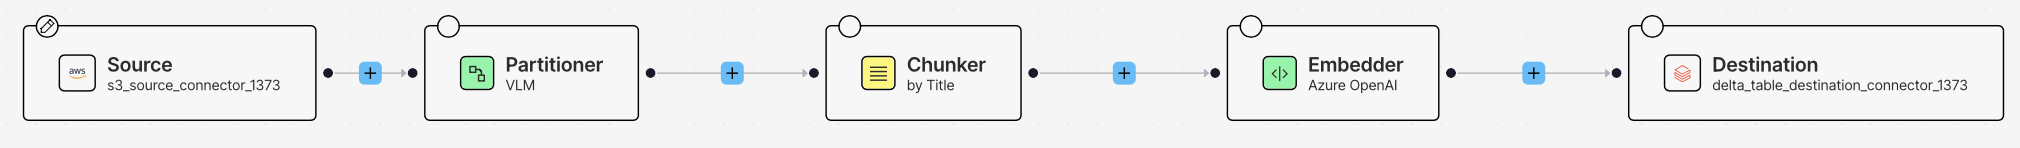


## Prerequisites

**Unstructured**

An Unstructured API key.


**AWS**

An Amazon Web Services (AWS) account, along with your AWS secret key and AWS secret access key for authentication. You'll also need Amazon S3 bucket with the correct access settings applied.


**Databricks**

You'll need to have a Databricks account, and if you're creating a new account, make sure to complete the cloud set up. Note down the URL of your workspace and check that you have Unity Catalog enabled in the workspace.

Within your Unity Catalog, you'll need:
* A catalog
* A schema
* A volume

For this guide you will also need to have a SQL warehouse, which will be used to create and manage tables in your schema. Once you create and start your SQL, copy the values for the Server hostname and HTTP path from the Connection Details tab.  



## Step 1: Install the Unstructured API Python SDK

All functionality available in the the UI of the [Unstructured](https://unstructured.io/) product is also available programmatically via Unstructured API. You can interact with Unstructured API either by sending direct requests via curl or postman, or using Unstructured API [Python SDK](https://docs.unstructured.io/api-reference/workflow/overview#unstructured-python-sdk). Here, we'll be using the latter.


> **Note:**
The Unstructured API has two endpoints:
* The Unstructured Partition Endpoint: intended for rapid prototyping of Unstructured's various partitioning strategies. It works only with processing of local files, one file at a time.
* The Unstructured Workflow Endpoint: enables a full range of partitioning, chunking, embedding, and enrichment options for your data. It is designed to batch-process data from any data source to any destination. This is what we're using in this notebook.


Run the following cell to install the Unstructured API Python SDK.

In [12]:
!pip install -U "unstructured-client"
!pip install python-dotenv==1.0.0

## Step 2: Set environment variables

Replace the placeholders with the values for your API keys, secrets, etc:

In [2]:


from google.colab import userdata

unstructured_api_key = userdata.get('UNSTRUCTURED_API_KEY')
aws_user_secret = userdata.get('AWS_SECRET')
databricks_sp_secret = userdata.get('DATABRICKS_SERVICEPRINCIPAL_SECRET')
databricks_token = userdata.get("DATABRICKS_TOKEN")


if unstructured_api_key:
  print("Unstructured API Key fetched successfully.")
else:
  print("Unstructured API Key not found. Please set it in the userdata.")

if aws_user_secret :
  print("AWS Credentials fetched successfully.")
else:
  print("AWS Credentials not found. Please set them in the userdata.")

if databricks_sp_secret:
  print("Databricks Credentials fetched successfully.")
else:
  print("Databricks Credentials not found. Please set them in the userdata.")


if databricks_token:
  print("Databricks token fetched successfully.")
else:
  print("Databricks token not found. Please set them in the userdata.")



Unstructured API Key fetched successfully.
AWS Credentials fetched successfully.
Databricks Credentials fetched successfully.
Databricks token fetched successfully.


In [7]:
import os
import dotenv
dotenv.load_dotenv(".env")  # Replace ".env" with the actual file path if needed


# Unstructured
os.environ['UNSTRUCTURED_API_KEY'] = unstructured_api_key

# Amazon S3
os.environ['AWS_S3_URI'] = ""
os.environ['AWS_KEY'] = ""
os.environ['AWS_SECRET'] = aws_user_secret

# Databricks
os.environ['SERVER_HOSTNAME'] = ""
os.environ['HTTP_PATH'] = ""
os.environ['CATALOG'] = ""
os.environ['VOLUME'] = ""
os.environ['SCHEMA'] = ""
os.environ['CLIENT_ID'] = ""
os.environ['CLIENT_SECRET'] = databricks_sp_secret

In [27]:
os.getenv("")

In [4]:
# instantiate Unstructured Client
from unstructured_client import UnstructuredClient

unstructured_client = UnstructuredClient(api_key_auth=os.getenv("UNSTRUCTURED_API_KEY"))

# helper function
def pretty_print_model(response_model):
    print(response_model.model_dump_json(indent=4))

## Step 3: Create the source connector

Run the following cell to create the  [S3 source connector](https://docs.unstructured.io/api-reference/workflow/sources/s3).
When creating a source connector, you need to give it a unique name, specify its type (e.g. S3, or Google Drive), and provide the configuration which typically contains the location of the source you're connecting to (e.g. S3 bucket URI, Google Drive folder) and authentication details.

In [5]:
from unstructured_client.models.operations import CreateSourceRequest
from unstructured_client import UnstructuredClient
from unstructured_client.models.shared import (
    CreateSourceConnector,
    SourceConnectorType,
    S3SourceConnectorConfigInput
)


response = unstructured_client.sources.create_source(
    request=CreateSourceRequest(
        create_source_connector=CreateSourceConnector(
            name="s3_source_connector",
            type=SourceConnectorType.S3,
            config=S3SourceConnectorConfigInput(
                key=os.getenv("AWS_KEY"),
                secret=os.getenv("AWS_SECRET"),
                remote_url=os.getenv("AWS_S3_URI"),
                recursive=False
            )
        )
    )
)

source_connector_id = response.source_connector_information.id

In [8]:
source_connector_id

'e8bc9f67-ce24-4d8c-b859-7299ae348184'

## Step 4: Create the destination connector

Before you create the destination connector for a Delta Table in Databricks, make sure to create a catalog, schema (formerly known as a database), and a volume in Unity Catalog if you do not already have them available.

You don't need to specify a table name—Unstructured will create one automatically! If you prefer to create your own table, just make sure it matches our schema requirements, which you can find in the [documentation](https://docs.unstructured.io/api-reference/workflow/destinations/databricks-delta-table).



In [25]:
from unstructured_client.models.operations import CreateDestinationRequest
from unstructured_client.models.shared import (
    CreateDestinationConnector,
    DestinationConnectorType,
    DatabricksVDTDestinationConnectorConfigInput
)


response = unstructured_client.destinations.create_destination(
    request=CreateDestinationRequest(
        create_destination_connector=CreateDestinationConnector(
            name="delta_table_destination_connector",
            type=DestinationConnectorType.DATABRICKS_VOLUME_DELTA_TABLES,
            config=DatabricksVDTDestinationConnectorConfigInput(
                server_hostname=os.getenv("SERVER_HOSTNAME"),
                http_path=os.getenv("HTTP_PATH"),
                # client_id=os.getenv("CLIENT_ID"),
                # client_secret=os.getenv("CLIENT_SECRET"),
                token=databricks_token,
                volume=os.getenv("VOLUME"),
                catalog=os.getenv("CATALOG"),
                schema=os.getenv("SCHEMA"),
                table_name="structured_data"
            )
        )
    )
)

destination_connector_id = response.destination_connector_information.id

In [47]:
destination_connector_id

'db00145a-4fac-4a14-b8a4-8e70b85bedd1'

## Step 5: Create the data processing workflow

A data processing workflow in Unstructured is a DAG (Directed acyclic graph) that ties together individual data processing steps.

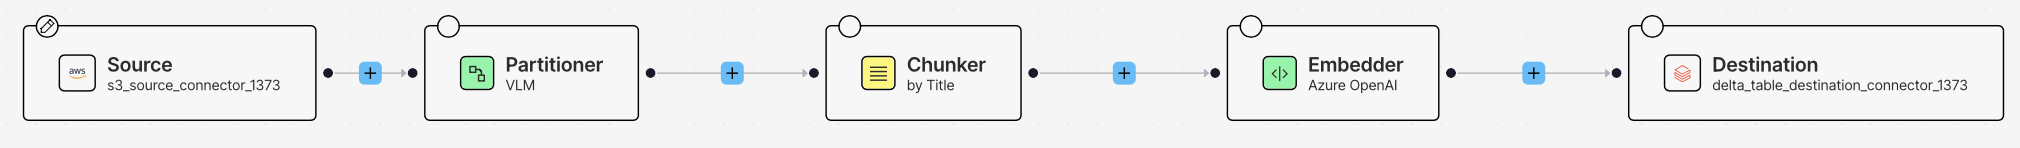

You can define each individual data processing step as a `WorkflowNode` and configure its parameters. The type of `WorkflowNode` determins what task it performs, while the settings specify how exactly it's executed. Let's take a closer look at the available Workflow Node types.

### `WorkflowNodeType.PARTITION`

This node is **required** in every workflow, and it has to be the first node in the DAG. Its task is to convert unstructured data into structured JSON format. Whether a document ingested from a source is a markdown file, email, or a PDF file, the resulting JSON file will have a standardized schema containing all of the document content and metadata. You can learn about the output JSON schema [here](https://docs.unstructured.io/api-reference/partition/document-elements).

At the time of writing, Unstructured offers 4 partitioning strategies:
* **Auto**, `subtype="vlm"`: A dynamic meta-strategy that selects the optimal partitioning approach—either `VLM`, `High Res`, or `Fast`—based on a document's unique characteristics, such as file type and page content. This strategy intelligently applies the most suitable method to minimize processing costs while maximizing accuracy.
* **VLM**, `subtype="vlm"`: A partitioning strategy that uses state-of-the-art VLMs (Vision-Language Models) to extract content from complex documents where traditional OCR struggles. It's ideal for challenging cases like noisy scans, handwriting, and complex nested forms.
* **High Res**, `subtype="unstructured_api"`: This approach combines advanced OCR with document understanding capabilities, making it effective for image-based documents like scanned files. Can handle documents with images and simple tables.
* **Fast**, `subtype="unstructured_api"`: A rapid strategy optimized for quick text extraction from documents such as markdown or office suite files. It's a cost-effective solution for documents with easily extractable text and no images.


### `WorkflowNodeType.PROMPTER`
Nodes of this type enrich your documents in one way or another. They can be used to generate image and/or table description, or extract named entities from the text to add to the metadata.
* **Image summarizer**: Enrichment that generates descriptions of images. Use one of the following subtypes: `openai_image_description`, `anthropic_image_description`, `bedrock_image_description`, `vertexai_image_description`.
* **Table summarizer**: Enrichment that generates descriptions of tables. Use one of the following subtypes: `openai_table_description`, `anthropic_table_description`, `bedrock_table_description`, `vertexai_table_description`.
* **Named entity recognizer**: Enrichment that generates extracts named entities from text and adds them as metadata. Can be used to build GraphRAG. Subtype: `openai_ner`.
* **Table to HTML**: Enrichment that converts adds the HTML version of a table to metadata. Subtype: `openai_table2html`.

In this example we won't be adding any enrichments.

### `WorkflowNodeType.CHUNK`

The chunking workflow node rearranges the document elements into manageable “chunks” to stay within the limits of an embedding model and to improve retrieval precision. You can learn more about chunking [here](https://docs.unstructured.io/ui/chunking).

### `WorkflowNodeType.EMBED`

After the data is partitioned, enriched and chunked, the embedding node can create vector representations of text, also called *embeddings*, that are used for similarity search in downstream applications. Learn mode about embeddings [here](https://docs.unstructured.io/ui/embedding)

Once you define your workflow nodes, you can create a workflow.
Run the following cell to create the workflow.

In [26]:
from unstructured_client.models.shared import (
    WorkflowNode,
    WorkflowNodeType,
    WorkflowType,
    Schedule
)

parition_node = WorkflowNode(
    name="Partitioner",
    subtype="vlm",
    type=WorkflowNodeType.PARTITION,
    settings={
        "provider": "anthropic",
        "model": "claude-3-7-sonnet-20250219",
        }
    )

chunk_node = WorkflowNode(
    name='Chunker',
    subtype='chunk_by_title',
    type=WorkflowNodeType.CHUNK,
    settings={
        'new_after_n_chars': 500,
        'max_characters': 700,
        'overlap': 60
        }
    )

embedder_node = WorkflowNode(
    name='Embedder',
    subtype='azure_openai',
    type=WorkflowNodeType.EMBED,
    settings={
        'model_name': 'text-embedding-3-small'
        }
    )


response = unstructured_client.workflows.create_workflow(
    request={
        "create_workflow": {
            "name": "s3-to-delta-table-custom-workflow-chunking",
            "source_id": source_connector_id,
            "destination_id": destination_connector_id,
            "workflow_type": WorkflowType.CUSTOM,
            "workflow_nodes": [
                parition_node,
                chunk_node,
                embedder_node
            ],
            "is_scheduled": False
            # "schedule": Schedule("monthly")
        }
    }
)

pretty_print_model(response.workflow_information)
workflow_id = response.workflow_information.id

{
    "created_at": "2025-04-11T12:09:26.925592Z",
    "destinations": [
        "8ef21f60-c308-40b9-b091-e8b3f86d975a"
    ],
    "id": "92d84113-85f8-4ab4-ba52-6bd1a71b26a8",
    "name": "s3-to-delta-table-custom-workflow-chunking",
    "sources": [
        "03d80315-560c-4463-88b0-4b3297b72d7a"
    ],
    "status": "active",
    "workflow_nodes": [
        {
            "name": "Partitioner",
            "subtype": "vlm",
            "type": "partition",
            "id": "64f23d2f-173c-4a56-b66c-7e367514a0e9",
            "settings": {
                "provider": "anthropic",
                "provider_api_key": null,
                "model": "claude-3-7-sonnet-20250219",
                "output_format": "text/html",
                "user_prompt": null,
                "format_html": true,
                "unique_element_ids": true,
                "is_dynamic": false,
                "allow_fast": true
            }
        },
        {
            "name": "Chunker",
            "s

## Step 6: Run the workflow

Run the following cell to start running the workflow.

In [27]:
res = unstructured_client.workflows.run_workflow(
    request={
        "workflow_id": workflow_id,
    }
)

pretty_print_model(res.job_information)

{
    "created_at": "2025-04-11T12:09:33.323453Z",
    "id": "95300c81-a9b8-4a1c-a03d-ed82fab455ce",
    "status": "SCHEDULED",
    "workflow_id": "92d84113-85f8-4ab4-ba52-6bd1a71b26a8",
    "workflow_name": "s3-to-delta-table-custom-workflow-chunking"
}


## Step 7: Get the workflow run's job ID

Run the following cell to get the workflow run's job ID, which is needed to poll for job completion later. If successful, Unstructured prints the job's ID.

In [28]:
response = unstructured_client.jobs.list_jobs(
    request={
        "workflow_id": workflow_id
    }
)

last_job = response.response_list_jobs[0]
job_id = last_job.id
print(f"job_id: {job_id}")

job_id: 95300c81-a9b8-4a1c-a03d-ed82fab455ce


## Step 8: Poll for job completion

Run the following cell to confirm the job has finished running. If successful, Unstructured prints `"status": "COMPLETED"` within the information about the job.

In [29]:
import time

def poll_job_status(job_id):
    while True:
        response = unstructured_client.jobs.get_job(
            request={
                "job_id": job_id
            }
        )

        job = response.job_information

        if job.status == "SCHEDULED":
            print("Job is scheduled, polling again in 10 seconds...")
            time.sleep(10)
        elif job.status == "IN_PROGRESS":
            print("Job is in progress, polling again in 10 seconds...")
            time.sleep(10)
        else:
            print("Job is completed")
            break

    return job

job = poll_job_status(job_id)
pretty_print_model(job)

Job is scheduled, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is in progress, polling again in 10 seconds...
Job is completed
{
    "created_at": "2025-04-11T12:09:33.323453",
    "id": "95300c81-a9b8-4a1c-a03d-ed82fab455ce",
    "status": "COMPLETED",
    "workflow_id": "92d84113-85f8-4ab4-ba52-6bd1a71b26a8",
    "workflow_name": "s3-to-delta-table-custom-workflow-chunking",
    "runtime": "PT0S"
}


## Step 9: View the processed data

Once the job is completed, your data is processed, and you can find it in your catalog under the schema you've specified. If you didn't provide a table name when setting up your destination connector, Unstructured will create a table that will have a name that starts with "u" (for Unstructured), followed by the first part of the workflow id (e.g. `cc88c7df`), and the embedding model details, if you have an Embedder node.

If Unstructured created the table, it will also initially be only accessible to your service principal. Give your user permissions to `SELECT` from this table to view the results:

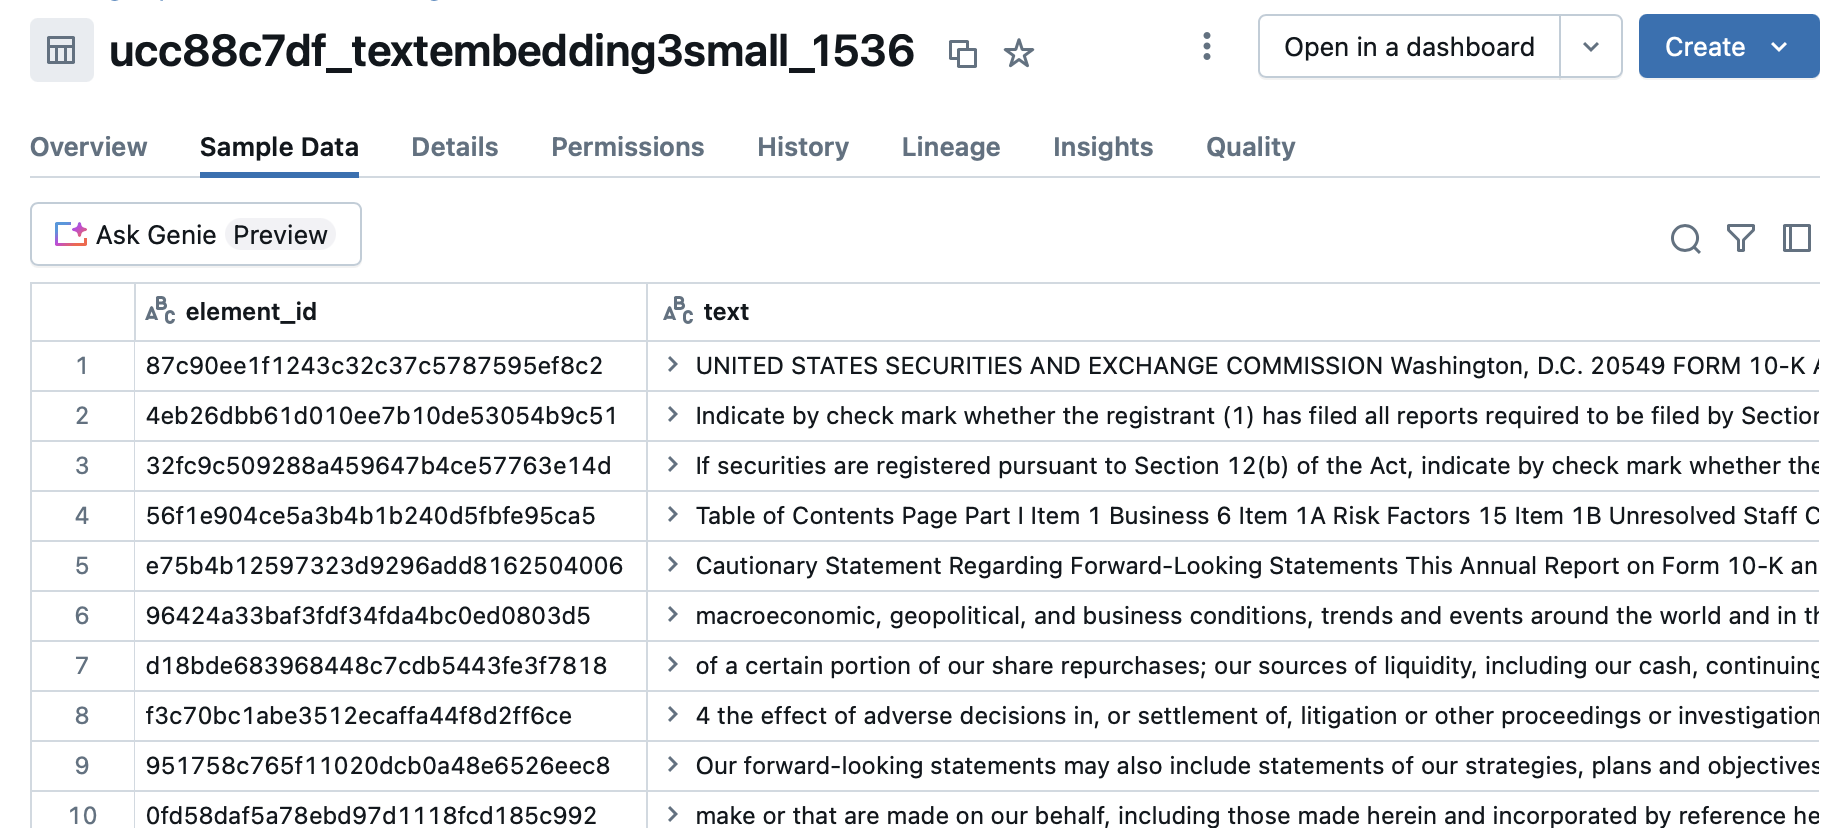